<a href="https://colab.research.google.com/github/johntronik/hello-world/blob/master/5_5_%E3%83%86%E3%83%B3%E3%82%BD%E3%83%AB%E5%88%86%E8%A7%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.5. テンソル分解
* テンソル分解（tensor factorization）を紹介
    1. 行列分解を使った場合の協調フィルタリング（collaborative filtering）
    2. テンソルの場合に拡張し，推論アルゴリズムを導出

# 1. 協調フィルタリング
## 協調フィルタリングとは 
協調フィルタリングとは : 推薦技術
* ユーザーの購買記録やレーティング（商品に対する評価値）データ  
=> 次にユーザーがどのようなアイテムに興味をもつかを予測

大別すると2タイプある
* メモリベース
    * 異なるユーザー i と j の間の類似度 Sim(i,j) を何らかの方法を使って計算することによって，ユーザーが興味をもちそうなアイテムを推薦する手法
* モデルベース
    * 線形次元削減 <- やった
    * 非負値行列因子分解 <- やった
    * テンソル分解 <- これから紹介

## 2次元版のテンソル分解
(5.172)式からなる生成モデルを考える。
* $R_{n,m}$ をユーザー$n$のアイテム$m$に対するレーティング値
* $U_{:,n}$ をユーザー$n$の特徴ベクトル
* $V_{:,m}$ をアイテム$m$の特徴ベクトル

R(n×m) ~ $U^T$(n×d) * V(d×m) (5.173)として(5.172)を行列で書き直すこともできる。

これはn×m次元のRをd×n次元のUとd×m次元のVで近似することと等しい  
-> 線形次元削減や非負値行列因子分解と一緒



## 3次元版のテンソル分解
* K:時間方向のインデックス により $R_{n,m,k}$と拡張する

(5.174)式へと拡張する($S_{d,k}$を拡張)

# 5.5.2 モデル
カーネギーメロン大学の機械学習部?の論文
reference:https://www.cs.cmu.edu/~jgc/publication/PublicationPDF/Temporal_Collaborative_Filtering_With_Bayesian_Probabilidtic_Tensor_Factorization.pdf

* (5.175)式 : $R_{n,m,k}$ は$U_n$, $V_m$, $S_k$ の積を平均、λを分散にとる正規分布
* (5.176)式 : $U_n$は正規分布
* (5.177)式 : $V_m$は正規分布
* (5.178)式 : $S_k$はマルコフ性を仮定した正規分布


* (5.179)式 : (5.175)式のλはガンマ分布を設定
* (5.180~182)式 : (5.176～178)式の平均、分散はガウスウィシャート分布

# 5.5.3 変分推論
(5.185)式 : 変分推論で(5.184)式を解いていく

# 5.5.4 欠損値の補完
(5.225)式 : 線形次元削減の欠損値補完をそのまま適用できる

2次元版のテンソル分解 実装

In [217]:
# データ準備
import pandas as pd
from tqdm import tqdm_notebook
import numpy as np
from numpy.linalg import inv
from numpy.random import multivariate_normal
from scipy.stats import wishart
from scipy.sparse import lil_matrix, coo_matrix

# toy data
r_origin = np.array([
    [0, 0, 7],
    [0, 1, 6],
#    [0, 2, 7],
    [0, 3, 4],
    [0, 4, 5],
    [0, 5, 4],
    [1, 0, 6],
#    [1, 1, 7],
    [1, 3, 4],
    [1, 4, 3],
    [1, 5, 4],
    [2, 1, 3],
    [2, 2, 3],
    [2, 3, 1],
    [2, 4, 1],
    [3, 0, 1],
    [3, 1, 2],
    [3, 2, 2],
    [3, 3, 3],
#    [3, 4, 3],
    [3, 5, 4],
    [4, 0, 1],
    [4, 2, 1],
#    [4, 3, 2],
    [4, 4, 3],
    [4, 5, 3]
])

# movie-lens data
names = ['user_id','item_id','rating','timestamp']
r_origin = pd.read_table('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', names=names)#.values
r_origin = r_origin[(r_origin.user_id<100)&(r_origin.item_id<500)].values

r = coo_matrix((r_origin[:, 2], (r_origin[:, 0], r_origin[:, 1])))
r = lil_matrix(r)
r.shape

(100, 500)

In [0]:
def bpmf_gibbs_sampling(R, D, n_sample):
    # 初期値(BPMFの論文と同じ)
    N,M = R.shape
    U = np.zeros((n_sample, N, D))
    V = np.zeros((n_sample, D, M))
    U[0, :, :] = np.random.rand(N, D)
    V[0, :, :] = np.random.rand(D, M)

    beta0 = 2
    mu0 = 0
    nu0 = D
    W0 = np.identity(D)
    alpha = 2

    for t_ in tqdm_notebook(range(n_sample - 1)):
        # sample lam_u
        S_bar = np.sum([np.outer(U[t_, i, :], U[t_, i, :].T) for i in range(N)], axis=0) / N
        U_bar = np.sum(U[t_], axis=0) / N
        W0_ast = inv(inv(W0) + N * S_bar +
                     (beta0 * N / (beta0 + N)) * np.outer(mu0 - U_bar, (mu0 - U_bar).T))
        lam_u = wishart.rvs(df=nu0 + N, scale=W0_ast)

        # sample mu_u
        mu0_ast =(beta0 * mu0 + N * U_bar) / (beta0 + N)
        mu_u = multivariate_normal(mu0_ast, inv((beta0 + N) * lam_u))

        # sample lam_v
        S_bar = np.sum([np.outer(V[t_, :, j], V[t_, :, j].T) for j in range(M)], axis=0) / M
        V_bar = np.sum(V[t_], axis=1) / M
        W0_ast = inv(inv(W0) + M * S_bar +
                     (beta0 * M / (beta0 + M)) * np.outer(mu0 - V_bar, (mu0 - V_bar).T))
        lam_v = wishart.rvs(df=nu0 + M, scale=W0_ast)

        # sample mu_v
        mu0_ast = (beta0 * mu0 + M * V_bar) / (beta0 + M)
        mu_v = multivariate_normal(mu0_ast, inv((beta0 + M) * lam_v))
        # sample U
        for i in range(N):
            V_VT_I = np.sum([np.outer(V[t_, :, j], V[t_, :, j].T)
                             for j in R.getrow(i).nonzero()[1]], axis=0)
            lam_ast_inv = inv(lam_u + alpha * V_VT_I)

            V_R_I = np.sum([V[t_, :, j] * r for j, r in zip(R.getrow(i).nonzero()[1],
                                                            R.getrow(i).data[0])], axis=0)
            mu_ast = lam_ast_inv.dot((alpha * V_R_I + lam_u.dot(mu_u.T)).T)

            U[t_ + 1, i, :] = multivariate_normal(mu_ast, lam_ast_inv)

        # sample V
        for j in range(M):
            U_UT_I = np.sum([np.outer(U[t_ + 1, i, :], U[t_ + 1, i, :].T)
                             for i in R.getcol(j).nonzero()[0]], axis=0)
            lam_ast_inv = inv(lam_v + alpha * U_UT_I)

            U_R_I = np.sum([U[t_ + 1, i, :] * r for i, r in zip(R.getcol(j).nonzero()[0],
                                                                R.getcol(j).data)], axis=0)
            mu_ast = lam_ast_inv.dot((alpha * U_R_I + lam_v.dot(mu_v.T)).T)

            V[t_ + 1, :, j] = multivariate_normal(mu_ast, lam_ast_inv)

    return U, V

In [203]:
np.random.seed(1)
n_sample=300
U, V = bpmf_gibbs_sampling(r, D=5, n_sample=n_sample)

burn_in = 100
p = np.empty(r.shape)
for u in range(r.shape[0]):
    for i in range(r.shape[1]):
        p[u, i] = np.mean(np.sum(U[burn_in:, u, :] * V[burn_in:, :, i], axis=1))

In [209]:
print('予測データ')
np.round(p,1)[:10,:10]

予測データ


array([[6.7, 6.1, 6.1, 4.2, 4.7, 4.4],
       [5.8, 5.2, 5.3, 3.8, 3.6, 3.8],
       [2.9, 2.6, 2.7, 1.3, 1.2, 1.4],
       [1.5, 2.2, 2. , 2.6, 2.9, 3.5],
       [1.2, 1.8, 1.3, 2.1, 2.6, 2.8]])

In [210]:
print('元データ')
pd.DataFrame(r_origin).pivot(0,1,2).values[:10,:10]#.astype(int)

元データ


array([[ 7.,  6., nan,  4.,  5.,  4.],
       [ 6., nan, nan,  4.,  3.,  4.],
       [nan,  3.,  3.,  1.,  1., nan],
       [ 1.,  2.,  2.,  3., nan,  4.],
       [ 1., nan,  1., nan,  3.,  3.]])

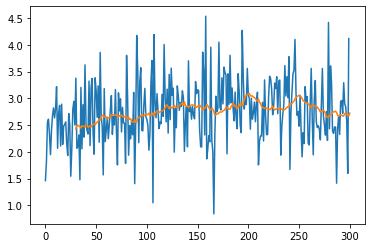

In [204]:
# burn-inが適正かどうか
y = np.sum(U[:, u, :] * V[:, :, i], axis=1)
from matplotlib import pyplot as plt
plt.plot(y[:])
num=30#移動平均の個数
b = np.ones(num)/num
y2 = np.convolve(y, b, mode='valid')
plt.plot(range(num, n_sample+1), y2)

In [218]:
np.random.seed(1)
n_sample=100
U, V = bpmf_gibbs_sampling(r, D=5, n_sample=n_sample)

burn_in = 30
p = np.empty(r.shape)
for u in range(r.shape[0]):
    for i in range(r.shape[1]):
        p[u, i] = np.mean(np.sum(U[burn_in:, u, :] * V[burn_in:, :, i], axis=1))

In [223]:
print('予測データ')
np.round(p,1)[:10,:13]

予測データ


array([[3.1, 3.8, 3. , 2.6, 3.7, 3.2, 4.2, 3.7, 4.1, 4.3, 3.8, 3.7, 4.4],
       [3.1, 3.7, 2.9, 3.3, 4.1, 2.7, 4.6, 4.3, 3.7, 4.2, 3.8, 2.9, 4.7],
       [3.1, 3.7, 2.7, 3. , 3.9, 3. , 4.5, 3.5, 4.6, 4.5, 3.6, 3.5, 4.7],
       [2.4, 3.2, 1.8, 3.4, 3.3, 2.2, 3.8, 4.3, 3.2, 3.3, 3.3, 3.5, 3.9],
       [3.5, 4.9, 3.5, 3.1, 4.2, 3.9, 4.8, 5.1, 4.6, 4.9, 5.1, 4.7, 5.2],
       [2.7, 3.8, 2.7, 2.5, 3.1, 2.7, 3.7, 4.4, 2.8, 3.6, 4. , 2.6, 4.2],
       [2.7, 3.3, 2.1, 2.8, 3.4, 2.8, 3.9, 3.1, 4.2, 4.1, 3.3, 3.6, 4.2],
       [3.4, 4.1, 3.3, 3. , 4.2, 3.4, 4.8, 3.8, 4.9, 4.9, 4.2, 3.7, 5.1],
       [3.3, 3.9, 3.2, 3.4, 4.3, 3. , 4.9, 4.2, 4.3, 4.5, 3.9, 3.3, 5. ],
       [3.7, 4.9, 3.7, 3. , 4.3, 4.1, 4.9, 4.3, 5.4, 5.2, 5. , 4.9, 5.3]])

In [224]:
print('元データ')
pd.DataFrame(r_origin).pivot(0,1,2).values[:10,:13]#.astype(int)

元データ


array([[ 5.,  3.,  4.,  3.,  3.,  5.,  4.,  1.,  5.,  3.,  2.,  5.,  5.],
       [ 4., nan, nan, nan, nan, nan, nan, nan, nan,  2., nan, nan,  4.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  4., nan, nan],
       [ 4.,  3., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 4., nan, nan, nan, nan, nan,  2.,  4.,  4., nan, nan,  4.,  2.],
       [nan, nan, nan,  5., nan, nan,  5.,  5.,  5.,  4.,  3.,  5., nan],
       [nan, nan, nan, nan, nan, nan,  3., nan, nan, nan,  3., nan, nan],
       [nan, nan, nan, nan, nan,  5.,  4., nan, nan, nan, nan, nan, nan],
       [ 4., nan, nan,  4., nan, nan,  4., nan,  4., nan,  4.,  5.,  3.]])